In [115]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [116]:
size = 10000
n_on = int(size * 0.01)
on_val = size // n_on
area = 0.05
expected_value = area**2 * on_val
print("EXPECTED VALUE:", expected_value)
print("VARIANCE:", (area**2 * on_val**2) - expected_value**2)

off_vals = tf.random.uniform([size - n_on, 2])
on_center = tf.clip_by_value(tf.random.uniform([2]), area * 4, 1 - (area * 4))
on_vals = on_center + tf.random.uniform([n_on, 2], maxval=area)
vals = np.concatenate([off_vals, on_vals])

labels = np.concatenate([tf.zeros(size - n_on), tf.ones(n_on) * on_val])
dataset = tf.data.Dataset.from_tensor_slices({"x": vals, "y": labels})

EXPECTED VALUE: 0.25000000000000006
VARIANCE: 24.937500000000004


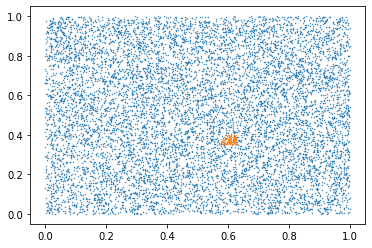

In [117]:
s = 0.2
plt.scatter(off_vals[:, 0], off_vals[:,1], s=s)
plt.scatter(on_vals[:, 0], on_vals[:,1], s=s)

In [118]:
layers = [64, 64, 64]

network = tf.keras.Sequential()
for n in layers:
    network.add(tf.keras.layers.Dense(n, activation=tf.nn.relu))
network.add(tf.keras.layers.Dense(1))

In [119]:
network.compile(tf.keras.optimizers.Adam(), tf.keras.losses.MeanSquaredError())
network.fit(vals, labels, epochs=100, batch_size=size // n_on)

Epoch 1/100
100/100 [==============================] - 0s 803us/step - loss: 99.2306
Epoch 2/100
100/100 [==============================] - 0s 939us/step - loss: 97.4765
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 95.6880
Epoch 4/100
100/100 [==============================] - 0s 820us/step - loss: 93.9753
Epoch 5/100
100/100 [==============================] - 0s 744us/step - loss: 91.5567
Epoch 6/100
100/100 [==============================] - 0s 744us/step - loss: 89.5235
Epoch 7/100
100/100 [==============================] - 0s 700us/step - loss: 87.4348
Epoch 8/100
100/100 [==============================] - 0s 717us/step - loss: 83.0604
Epoch 9/100
100/100 [==============================] - 0s 716us/step - loss: 81.2380
Epoch 10/100
100/100 [==============================] - 0s 728us/step - loss: 78.5168
Epoch 11/100
100/100 [==============================] - 0s 733us/step - loss: 75.9371
Epoch 12/100
100/100 [==============================] - 0s 713us/

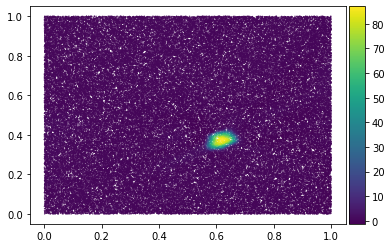

In [120]:
def scatter(inputs, outputs):
    ax = plt.subplot()
    im = ax.scatter(inputs[:, 0], inputs[:, 1], s=s, c=outputs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

# check fit
samples = tf.random.uniform([100000, 2])
scatter(samples, network(samples))

In [121]:
n_samples = 10000000
def mc():
    samples = tf.random.uniform([n_samples, 2])
    values = tf.squeeze(network(samples))
    scatter(samples[:100000], values[:100000])
    return tf.cumsum(values) / tf.range(1, n_samples + 1, dtype=tf.float32), samples, values

def importance_sample():
    bias_shift = 0 # tf.random.uniform([2], maxval=area)
    deltas = tf.random.uniform([n_samples, 2], maxval=area*4) - area*2
    samples = (on_center + bias_shift) + deltas
    values = tf.squeeze(network(samples))
    scatter(samples[:100000], values[:100000])
    return 0.04 * tf.cumsum(values) / tf.range(1, n_samples + 1, dtype=tf.float32), samples, values

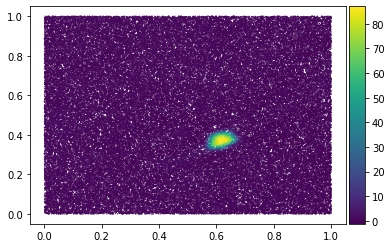

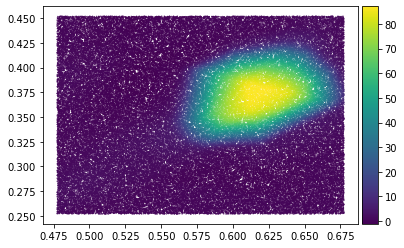

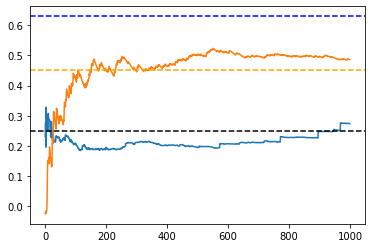

In [122]:
mc_est, samples, values = mc()
iw_est, samples, values = importance_sample()
plt.plot(mc_est[:1000])
plt.plot(iw_est[:1000])
plt.axhline(y = mc_est[-1], color = 'blue', linestyle = '--')
plt.axhline(y = iw_est[-1], color = 'orange', linestyle = '--')
plt.axhline(y = expected_value, color = 'black', linestyle = '--')